# core interfaceを用いた古典イジング模型の数値シミュレーション

このチュートリアルではOpenJijのcore interface (core python interface)を用いて、ランダム相互作用およびランダムな縦磁場をもつイジング模型の数値シミュレーションを行います。

まずはGraphを定義し、今回数値シミュレーションを行いたい系の$J_{ij}, h_i$を定義します。

In [1]:
import openjij.cxxjij.graph as G
#問題サイズを100とします。
N = 100

graph = G.Dense(N)
#sparseの場合は以下を使用します。
#graph = G.Sparse(N)

次に、$J_{ij}, h_i$を設定します。
今回は平均0、標準偏差1のGauss分布から生成される値を設定します。

In [ ]:
!pip install numpy #乱数生成にnumpyを使います。

In [2]:
import numpy as np
mu, sigma = 0, 1

for i in range(N):
    for j in range(N):
        #Jijの値が大きくなりすぎてしまうので、1/Nで規格化を行なっています。
        graph[i,j] = 0 if i == j else np.random.normal()/N

for i in range(N):
    graph[i] = np.random.normal()/N

縦磁場に関しては、`graph[i]`でも、`graph[i,i]`でもどちらでもアクセスできます。また、イジングモデルの定義上、$J_{ij}$と$J_{ji}$は自動で同じ値となります。試しに以下のように出力を行なってみましょう。

In [3]:
graph[20] = 0.5
print(graph[20,20])
print(graph[20])
graph[12,34] = -0.6
print(graph[12,34])
print(graph[34,12])

0.5
0.5
-0.6
-0.6


## システムの設定 - System -

続いて計算を行うためのシステムを定義します。  

ここでは古典イジング模型の数値シミュレーションを行いたいので古典イジング模型のシステムを作成してみます。`system.make_classical_ising`で作成できます。

In [4]:
import openjij.cxxjij.system as S

mysystem = S.make_classical_ising(graph.gen_spin(), graph)

ここで、1つ目の引数にはランダムに生成したスピン、2つめにはGraphそのものを代入します。これにより初期のスピン配位が`graph.gen_spin()`となる古典イジング模型のシステムの作成ができます。

システムに直接アクセスして、値を読むことも可能です。

In [5]:
print(mysystem.spin)

[ 1. -1.  1.  1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.
  1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1. -1.
  1. -1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1.
  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. -1.  1.  1.
 -1. -1. -1. -1.  1. -1.  1. -1. -1.  1. -1.  1. -1. -1.  1.  1. -1.  1.
 -1. -1.  1. -1. -1.  1.  1.  1.  1.  1.  1.]


## アルゴリズムの実行 -Updater, Algorithm-

Systemを定義した後はUpdaterを選択し、Algorithmを実行していきます。

### Updater

Systemに対して使用できるUpdaterは決められており、古典イジング模型に対するUpdaterは主に

- [SingleSpinFlip](https://github.com/OpenJij/OpenJij/blob/ec41aecfbac7e4c895e1e7a1718f06eb7ffae0ba/src/updater/single_spin_flip.hpp#L40) (メトロポリス・ヘイスティング法によるスピン1つずつのアップデート)
- [SwendsenWang](https://github.com/OpenJij/OpenJij/blob/ec41aecfbac7e4c895e1e7a1718f06eb7ffae0ba/src/updater/swendsen_wang.hpp#L45) (SwendsenWang法によるクラスターアップデート)

の2つが用意されています。
Algorithmを実行するには、**スケジュールリスト**が必要になります。まずスケジュールリストを作成するところから始めましょう。

### Algorithm

#### スケジュールリスト

スケジュールリストは`(パラメータ, モンテカルロステップ数)`のリストで与えられるものです。パラメータ部分に入力する値はSystemによって異なります。例えば、古典イジング模型ならばパラメータとして温度の逆数である逆温度$\beta$を設定します。
なので、古典イジング模型の場合には、温度スケジュールのリストを指しています。
ここでは、例として以下のように設定してみましょう。

In [6]:
schedule_list = [(0.01, 10),(10, 80),(0.1, 30)]

この場合、逆温度$\beta=0.01$で10モンテカルロステップ、$\beta=10$で80ステップ、$\beta=0.1$で30ステップの計120モンテカルロステップを実行することを意味します。  
アニーリングを実行するにあたっては、逆温度は等比級数で増加させていくことが多いため、以下のように`utility`にある`make_classical_schedule_list`を使うと逆温度は等比級数で増加させていくスケジュールを簡単に作成することができます。

In [7]:
import openjij.cxxjij.utility as U
schedule_list = U.make_classical_schedule_list(0.1, 50, 20, 10)
print(schedule_list)

[((beta: 0.100000) mcs: 20), ((beta: 0.199474) mcs: 20), ((beta: 0.397897) mcs: 20), ((beta: 0.793701) mcs: 20), ((beta: 1.583223) mcs: 20), ((beta: 3.158114) mcs: 20), ((beta: 6.299605) mcs: 20), ((beta: 12.566053) mcs: 20), ((beta: 25.065966) mcs: 20), ((beta: 50.000000) mcs: 20)]


上の例では$\beta=0.1$から$\beta=50$まで、各温度で20モンテカルロステップ計算しながら10段階で温度を変えていく設定例です。計200モンテカルロステップの計算を行います。

#### Algorithmの実行

続いて、Algorithmを実行します。`Algorithm_[Updater]_run`のように書くことで、指定したUpdaterで計算を行います。次の例ではSingleSpinFlipを実行しています。

In [8]:
import openjij.cxxjij.algorithm as A
A.Algorithm_SingleSpinFlip_run(mysystem, schedule_list)

一瞬で処理が終わりましたが、この間に計200モンテカルロステップの計算が行われています。
> `A.Algorithm_SingleSpinFlip_run(mysystem, seed, schedule_list)`とすることで、seedを固定したまま計算を行うことができます。結果に再現性をもたせたい際に使うことができます。

callbackを使用することで、Algorithmの実行中に1モンテカルロステップごとのシステムを取得することができます。古典イジング模型の場合は、システムとパラメータ (逆温度)を引数を持つ関数を作成すれば良いです。  
例として、以下ではシステムのエネルギーの値を記録するcallbackを作っています。

In [9]:
energies = []

def callback_log_energy(system, beta):
    #graphは以前にGraphモジュールにて定義したオブジェクトです
    energies.append(graph.calc_energy(system.spin))

このcallbackを用いて同じAlgorithmを実行します。

In [10]:
#スケジュールをもっと長く取ります (計20000モンテカルロステップ)
schedule_list = U.make_classical_schedule_list(0.1, 50, 200, 100)
A.Algorithm_SingleSpinFlip_run(mysystem, schedule_list, callback_log_energy)

記録したシステムのエネルギーを、横軸をモンテカルロステップ、縦軸をエネルギーでプロットすると次のようになります。

In [11]:
!pip install matplotlib

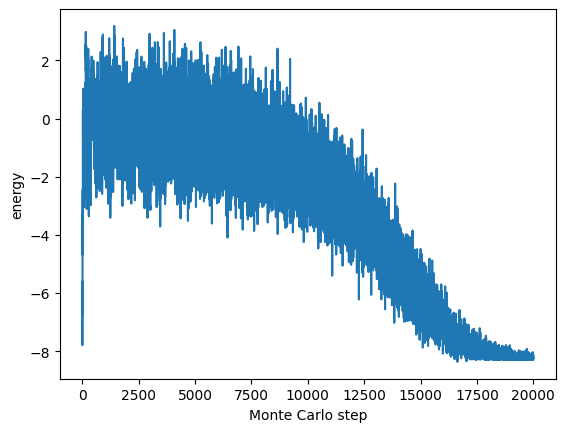

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(len(energies)), energies)
plt.xlabel('Monte Carlo step')
plt.ylabel('energy')
plt.show()

アニーリングが進むに連れ徐々にエネルギーが低くなっているのが分かります。

このようにcallbackは、Algorithmの動作中にシステムの様子を知りたい時に有用です。

## 結果の取得 -Result-

`result.get_solution`で計算結果であるスピン列を取得できます。古典イジング模型の場合は直接`mysystem.spin`を参照することで、スピン列を取得も可能です。しかし、`result.get_solution`はそれ以外のシステムについてもスピン列を取得できる便利なメソッドです。

In [13]:
import openjij.cxxjij.result as R
print(R.get_solution(mysystem))

[1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1]


このスピン列がアニーリングによって得られた答えです。ハミルトニアンの基底状態 (に近い状態)であることが期待されます。